In [51]:
from collections import deque, namedtuple
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.nn import functional as F
import torch.nn as nn
%matplotlib inline

In [52]:
env = gym.make("LunarLander-v3")

In [53]:
num_actions = env.action_space.n
num_actions

np.int64(4)

Actions:

0 - do nothing

1 - fire right engine

2 - fire main engine

3 - fire left engine

In [54]:
env.observation_space.shape

(8,)

In [55]:
curr_state = env.reset()

In [56]:
observation, reward, terminated, truncated, info = env.step(1)

In [57]:
reward

np.float64(1.8968777426519818)

In [90]:
# constants
SEED = 42
MINIBATCH_SIZE = 64
LEARNING_RATE = 1e-3
TAU = 1e-3  # soft update param
E_DECAY = 0.995  # ε-decay rate
E_MIN = 0.01  # min ε value
GAMMA = 0.99 # discount

In [94]:
state_size = 8
hidden_dim = 64

q_net = nn.Sequential(
    nn.Linear(state_size, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, hidden_dim), 
    nn.ReLU(),
    nn.Linear(hidden_dim, num_actions) # q vals
)

target_net = nn.Sequential(
    nn.Linear(state_size, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, hidden_dim), 
    nn.ReLU(),
    nn.Linear(hidden_dim, num_actions)
)

# copy initial weights from Q network to target network
target_net.load_state_dict(q_net.state_dict())

optimizer = torch.optim.Adam(q_net.parameters(), lr=LEARNING_RATE)

In [95]:
# experience replay (see readme)
experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'next_state', 'done'])

In [87]:
import random

def get_action(vals: torch.Tensor, eps: float):
    if random.random() > eps: 
        return np.argmax(vals.detach().numpy()[0])
    else:
        return random.randint(0, num_actions - 1) # completely random

In [88]:
def get_experiences(experiences):
    state = torch.tensor([e.state for e in experiences if e is not None]).float()
    action = torch.tensor([e.action for e in experiences if e is not None]).float()
    reward = torch.tensor([e.reward for e in experiences if e is not None]).float()
    next_state = torch.tensor([e.next_state for e in experiences if e is not None]).float()
    done = torch.tensor([e.done for e in experiences if e is not None]).float()
    return (state,action,reward,next_state,done)

$$
\begin{equation}
    y_j =
    \begin{cases}
      R_j & \text{if episode terminates at step  } j+1\\
      R_j + \gamma \max_{a'}\hat{Q}(s_{j+1},a') & \text{otherwise}\\
    \end{cases}       
\end{equation}
$$

In [96]:
import time

num_episodes = 3000
max_num_timesteps = 1000
num_update_steps = 8
point_history = []
num_avg_points = 100
eps = 1.0 # decay over time
memory_buffer = deque(maxlen=100_000) 

start = time.time()

for i in range(num_episodes):
    state = env.reset()[0]
    total_points = 0

    for t in range(max_num_timesteps): 
        state_q = torch.tensor(state).unsqueeze(0)  # (1, 8)
        q_vals = q_net(state_q)
        action = get_action(q_vals, eps)

        observation, reward, terminated, _, _ = env.step(action)
        memory_buffer.append(experience(state, action, reward, observation, terminated))

        if (t + 1) % num_update_steps == 0 and len(memory_buffer) > MINIBATCH_SIZE:
            experiences = random.sample(memory_buffer, MINIBATCH_SIZE)
            states, actions, rewards, next_states, done = get_experiences(experiences)
            next_q_values = target_net(next_states)
            max_qsa = torch.max(next_q_values, dim=1)[0]
            # conv to float 
            done = done.float()
            # compute targets
            y_targets = rewards + (1-done) * GAMMA * max_qsa # (1 - done) with done being == 1 if terminated
            # compute preds 
            q_vals = q_net(states)
            q_vals = q_vals.gather(1, actions.unsqueeze(-1).long()).squeeze(-1)
            # loss
            loss = F.mse_loss(q_vals, y_targets)
            optimizer.zero_grad()
            loss.backward()
            # update main net
            optimizer.step()
            # update target net - slow update
            for target_weights, q_weights in zip(target_net.parameters(), q_net.parameters()):
                target_weights.data.copy_(TAU * q_weights.data + (1-TAU) * target_weights.data)
            
        # update curr state
        state = observation.copy()
        total_points += reward
        
        if terminated:
            break

    eps = max(E_MIN, eps * E_DECAY)
    
    point_history.append(total_points)
    latest_points_avg = np.mean(point_history[-num_avg_points:])
    print(f"\rEpisode {i+1} | Total point average of the last {num_avg_points} episodes: {latest_points_avg:.2f}", end="")

    if latest_points_avg >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        torch.save(q_net.state_dict(), 'lunar_lander_model.pt')
        break

total_time = time.time() - start
print(f'total time: {total_time}s')

Episode 1764 | Total point average of the last 100 episodes: 200.27

Environment solved in 1764 episodes!
total time: 179.72617983818054s


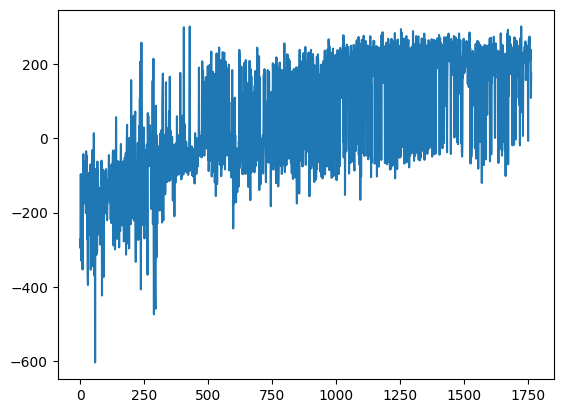

In [97]:
plt.plot(point_history)

In [113]:
import os
os.environ["IMAGEIO_FFMPEG_EXE"] = "/opt/homebrew/bin/ffmpeg" # if using mac brew install ffmpeg

import base64
import imageio
import IPython

def create_video(filename, q_network, fps=30):
    with imageio.get_writer(filename, fps=fps) as video:
        terminated = False
        env = gym.make("LunarLander-v3", render_mode="rgb_array")
        state = env.reset()[0]
        frame = env.render()
        video.append_data(frame)
        while not terminated:
            state = torch.tensor(state).unsqueeze(0)
            q_values = q_network(state)
            action = np.argmax(q_values.detach().numpy()[0])
            state, _, terminated, _, _ = env.step(action)
            frame = env.render()
            video.append_data(frame)

def embed_mp4(filename):
    video = open(filename, "rb").read()
    b64 = base64.b64encode(video)
    tag = """
    <video width="840" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>""".format(
        b64.decode()
    )

    return IPython.display.HTML(tag)

filename = 'lunar_lander.mp4'
create_video(filename, q_net)
embed_mp4(filename)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
